<a href="https://colab.research.google.com/github/MoonL1ght/ML-Things/blob/master/COLAB/FaceVerification/FaceVerif.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Colab Info

In [0]:
!pip3 install http://download.pytorch.org/whl/cu92/torch-0.4.1-cp36-cp36m-linux_x86_64.whl
!pip3 install torchvision

    100% |████████████████████████████████| 512.6MB 92.6MB/s 
fastai 1.0.49 has requirement numpy>=1.15, but you'll have numpy 1.14.6 which is incompatible.
fastai 1.0.49 has requirement torch>=1.0.0, but you'll have torch 0.4.1 which is incompatible.
  Found existing installation: torch 1.0.1.post2
    Uninstalling torch-1.0.1.post2:
      Successfully uninstalled torch-1.0.1.post2


In [2]:

# memory footprint support libraries/code
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
    process = psutil.Process(os.getpid())
    print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
    print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm() 

  Stored in directory: /root/.cache/pip/wheels/3d/77/07/80562de4bb0786e5ea186911a2c831fdd0018bda69beab71fd
Successfully built gputil
Gen RAM Free: 12.9 GB  | Proc size: 143.7 MB
GPU RAM Free: 11441MB | Used: 0MB | Util   0% | Total 11441MB


In [5]:
device = torch.cuda.current_device()
print(device)
print(torch.cuda.device(device))
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0))

0
1
Tesla K80


# One Shot Learning with Siamese Networks

In [0]:
%matplotlib inline
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2
from torch.utils.data import DataLoader, Dataset
import torchvision
import torchvision.datasets as dset
import os
import torchvision.transforms as transforms
import torchvision.transforms.functional as VF
from PIL import Image
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

## Load AT&T face dataset

In [6]:
!wget http://www.cl.cam.ac.uk/Research/DTG/attarchive/pub/data/att_faces.zip

--2019-04-01 09:26:45--  http://www.cl.cam.ac.uk/Research/DTG/attarchive/pub/data/att_faces.zip
Resolving www.cl.cam.ac.uk (www.cl.cam.ac.uk)... 128.232.0.20, 2a05:b400:110::80:14
Connecting to www.cl.cam.ac.uk (www.cl.cam.ac.uk)|128.232.0.20|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.cl.cam.ac.uk/Research/DTG/attarchive/pub/data/att_faces.zip [following]
--2019-04-01 09:26:46--  https://www.cl.cam.ac.uk/Research/DTG/attarchive/pub/data/att_faces.zip
Connecting to www.cl.cam.ac.uk (www.cl.cam.ac.uk)|128.232.0.20|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://www.cl.cam.ac.uk/research/dtg/attarchive/pub/data/att_faces.zip [following]
--2019-04-01 09:26:47--  https://www.cl.cam.ac.uk/research/dtg/attarchive/pub/data/att_faces.zip
Reusing existing connection to www.cl.cam.ac.uk:443.
HTTP request sent, awaiting response... 200 OK
Length: 3769022 (3.6M) [application/zip]
Saving to: ‘att_faces.

In [7]:
!pwd
!mkdir data
!mkdir data/att
!ls -la

/content
total 3708
drwxr-xr-x 1 root root    4096 Apr  1 09:26 .
drwxr-xr-x 1 root root    4096 Apr  1 09:24 ..
-rw-r--r-- 1 root root 3769022 Jun 28  2005 att_faces.zip
drwxr-xr-x 1 root root    4096 Mar 27 20:25 .config
drwxr-xr-x 3 root root    4096 Apr  1 09:27 data
drwxr-xr-x 1 root root    4096 Mar 27 20:26 sample_data


In [8]:
!unzip att_faces.zip -d data/att

Archive:  att_faces.zip
  inflating: data/att/README         
   creating: data/att/s1/
  inflating: data/att/s1/6.pgm       
  inflating: data/att/s1/7.pgm       
  inflating: data/att/s1/8.pgm       
  inflating: data/att/s1/9.pgm       
  inflating: data/att/s1/10.pgm      
  inflating: data/att/s1/1.pgm       
  inflating: data/att/s1/2.pgm       
  inflating: data/att/s1/3.pgm       
  inflating: data/att/s1/4.pgm       
  inflating: data/att/s1/5.pgm       
   creating: data/att/s2/
  inflating: data/att/s2/6.pgm       
  inflating: data/att/s2/7.pgm       
  inflating: data/att/s2/8.pgm       
  inflating: data/att/s2/9.pgm       
  inflating: data/att/s2/10.pgm      
  inflating: data/att/s2/1.pgm       
  inflating: data/att/s2/2.pgm       
  inflating: data/att/s2/3.pgm       
  inflating: data/att/s2/4.pgm       
  inflating: data/att/s2/5.pgm       
   creating: data/att/s3/
  inflating: data/att/s3/6.pgm       
  inflating: data/att/s3/7.pgm       
  inflating: data/att/s3

In [9]:
!ls data/att

README	s11  s14  s17  s2   s22  s25  s28  s30	s33  s36  s39  s5  s8
s1	s12  s15  s18  s20  s23  s26  s29  s31	s34  s37  s4   s6  s9
s10	s13  s16  s19  s21  s24  s27  s3   s32	s35  s38  s40  s7


['./data/att/s19/4.pgm']
./data/att/s19/4.pgm
(112, 92, 3)


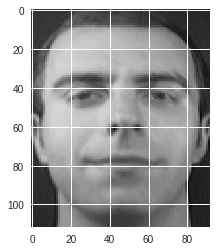

In [10]:
def image_example():
    path = './data/att/s19/'
    images_p = [path + img for img in os.listdir(path)][:1]
    print(images_p)
    for img_p in images_p:
        img = cv2.imread(img_p)
        print(img_p)
        print(img.shape)
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.show()

image_example()

## Dataset

In [0]:
def imshow(img, text=None):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
                 bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
    print(np.transpose(npimg, (1, 2, 0)).shape)
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    
def show_plot(iteration,loss):
    plt.plot(iteration,loss)
    plt.show()

In [0]:
class Config():
    path_att = './data/att/'
    train_batch_size = 64
    train_number_epochs = 100

In [0]:
class SiameseDataset(Dataset):
    def __init__(self, imageFolderDataset, transform=None):
        self.imageFolderDataset = imageFolderDataset
        self.transform = transform
        
    def __getitem__(self, index):
        #anchor image or true image
#         np.random.seed(42)
        idx = np.random.randint(0, len(self.imageFolderDataset.imgs))
        anchor = self.imageFolderDataset.imgs[idx]
    
        should_get_same_class = np.random.randint(0, 2) 
        if should_get_same_class:
            while True:
                #keep looping till the same class image is found
                idx = np.random.randint(0, len(self.imageFolderDataset.imgs))
                img1_tuple = self.imageFolderDataset.imgs[idx]
                if anchor[1]==img1_tuple[1]:
                    break
        else:
            while True:
                #keep looping till a different class image is found
                idx = np.random.randint(0, len(self.imageFolderDataset.imgs))
                img1_tuple = self.imageFolderDataset.imgs[idx] 
                if anchor[1] !=img1_tuple[1]:
                    break
        
#         anchor_img = Image.open(anchor[0])
#         img = Image.open(img1_tuple[0])
#         anchor_img = anchor_img.convert("L")
#         img = img.convert("L")
        anchor_img = cv2.imread(anchor[0])
        anchor_img = cv2.cvtColor(anchor_img, cv2.COLOR_BGR2GRAY)
        anchor_img = torch.from_numpy(anchor_img)
        anchor_img = VF.to_pil_image(anchor_img)
        img = cv2.imread(img1_tuple[0])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img = torch.from_numpy(img)
        img = VF.to_pil_image(img)
        
        if self.transform is not None:
            anchor_img = self.transform(anchor_img)
            img = self.transform(img)
        
        # 0 - equal images, 1 - not equal
        target = torch.from_numpy(np.array([int(anchor[1]!=img1_tuple[1])], dtype=np.float32))
        return anchor_img, img, target
    
    def __len__(self):
        return len(self.imageFolderDataset.imgs)

## Testing Dataset

Dataset ImageFolder
    Number of datapoints: 400
    Root Location: ./data/att/
    Transforms (if any): None
    Target Transforms (if any): None
tensor([[1.]])
torch.Size([2, 1, 100, 100])
(104, 206, 3)


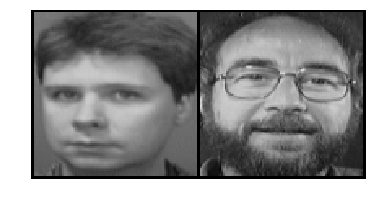

In [14]:
def test_dataset():
    folder_dataset = dset.ImageFolder(root=Config.path_att)
    print(folder_dataset)
    siamese_dataset = SiameseDataset(imageFolderDataset=folder_dataset,
                                     transform=transforms.Compose([transforms.Resize((100,100)),
                                                                   transforms.ToTensor()]))
    vis_dataloader = DataLoader(siamese_dataset, shuffle=True, num_workers=8,
                                batch_size=1)
    dataiter = iter(vis_dataloader)
    example_batch = next(dataiter)
    concatenated = torch.cat((example_batch[0], example_batch[1]), 0)
    print(example_batch[-1])
    print(concatenated.shape)
    imshow(torchvision.utils.make_grid(concatenated))

test_dataset()

## Siamese Network with standart CNN

In [0]:
class NetworkConfig():
    def conv(in_channels, out_channels, kernel_size, stride=1, padding=True,
             activation='leaky', batch_norm=True):
        return {'in_channels': in_channels, 'out_channels': out_channels,
                'kernel_size': kernel_size, 'stride': stride,
                'padding': padding, 'activation': activation,
                'batch_norm': batch_norm, 'type': 'conv'}

    def fc(in_size, out_size, activation='leaky'):
        return {
            'in_size': in_size,
            'out_size': out_size,
            'activation': activation,
            'type': 'fc'
        }

net_config = {
    'conv_1': NetworkConfig.conv(in_channels=1, out_channels=8, kernel_size=3),
    'conv_2': NetworkConfig.conv(in_channels=8, out_channels=16, kernel_size=3),
    'conv_3': NetworkConfig.conv(in_channels=16, out_channels=16, kernel_size=3),
    'fc_1': NetworkConfig.fc(in_size=16*100*100, out_size=1000),
    'fc_2': NetworkConfig.fc(in_size=1000, out_size=500),
    'out': NetworkConfig.fc(in_size=500, out_size=5, activation=None)
}

In [0]:
class SiameseNetwork(nn.Module):
    def __init__(self, net_config):
        super(SiameseNetwork, self).__init__()
        self.config = config
        self.network = self.create_cnn_layers()
        
    def _forward(self, x):
        for i, layer in enumerate(self.network):
            if i == self.number_of_convs:
                x = layer(x.view(x.size()[0], -1))
            else:
                x = layer(x)
        return x
    
    def forward(self, anchor, img):
        anchor = self._forward(anchor)
        img = self._forward(img)
        return anchor, img
        
    def create_cnn_layers(self):
        module_list = nn.ModuleList()
        self.number_of_convs = 0
        for i, layer in enumerate(self.config):
            module = nn.Sequential()
            conf = self.config[layer]
            if conf['type'] == 'conv':
                self.number_of_convs += 1
                activation = conf['activation']
                in_channels = int(conf['in_channels'])
                out_channels= int(conf['out_channels'])
                padding = int(conf['padding'])
                kernel_size = int(conf['kernel_size'])
                stride = int(conf['stride'])
                if padding:
                    pad = (kernel_size - 1) // 2
                else:
                    pad = 0
                conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, pad)
                module.add_module('conv_{0}'.format(i), conv)
                batch_normalize = conf['batch_norm']
                if batch_normalize:
                    bn = nn.BatchNorm2d(out_channels)
                    module.add_module('batch_norm_{0}'.format(i), bn)
            elif conf['type'] == 'fc':
                in_size = int(conf['in_size'])
                out_size= int(conf['out_size'])
                fc = nn.Linear(in_size, out_size)
                module.add_module(layer, fc)
            if activation == 'leaky':
                activn = nn.LeakyReLU(0.1, inplace = True)
            elif activation == 'relu':
                activn = nn.ReLU(inplace=True)
            module.add_module(activation + '_{0}'.format(i), activn)
            module_list.append(module)
        return module_list
                
            

In [0]:
class ContrastiveLoss(torch.nn.Module):
    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2)
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))
        return loss_contrastive

In [20]:
net = SiameseNetwork(config)
print(net)
folder_dataset = dset.ImageFolder(root=Config.path_att)
print(folder_dataset)
siamese_dataset = SiameseDataset(imageFolderDataset=folder_dataset,
                                     transform=transforms.Compose([transforms.Resize((100,100)),
                                                                   transforms.ToTensor()]))
vis_dataloader = DataLoader(siamese_dataset, shuffle=True, num_workers=8,
                                batch_size=1)
dataiter = iter(vis_dataloader)
example_batch = next(dataiter)
print(example_batch[0][0].view(1, 1, 100, 100).shape)

net(example_batch[0][0].view(1, 1, 100, 100)).shape


SiameseNetwork(
  (network): ModuleList(
    (0): Sequential(
      (conv_0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (batch_norm_0): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (leaky_0): LeakyReLU(negative_slope=0.1, inplace)
    )
    (1): Sequential(
      (conv_1): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (batch_norm_1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (leaky_1): LeakyReLU(negative_slope=0.1, inplace)
    )
    (2): Sequential(
      (conv_2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (batch_norm_2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (leaky_2): LeakyReLU(negative_slope=0.1, inplace)
    )
    (3): Sequential(
      (fc_1): Linear(in_features=160000, out_features=1000, bias=True)
      (leaky_3): LeakyReLU(negative_slope=0.1, inplace)
    )
    (4):

torch.Size([1, 5])

## Training

In [0]:
train_dataloader = DataLoader(siamese_dataset,
                              shuffle=True,
                              num_workers=8,
                              batch_size=Config.train_batch_size)

In [0]:

net = SiameseNetwork(net_config).cuda()
criterion = ContrastiveLoss()
optimizer = optim.Adam(net.parameters(),lr = 0.0005 )

Epoch number 0
 Current loss 2.1175832748413086

Epoch number 1
 Current loss 1.4184356927871704

Epoch number 2
 Current loss 1.1373987197875977

Epoch number 3
 Current loss 1.140974521636963

Epoch number 4
 Current loss 1.1300123929977417

Epoch number 5
 Current loss 1.1163939237594604

Epoch number 6
 Current loss 1.1128480434417725

Epoch number 7
 Current loss 1.1385167837142944

Epoch number 8
 Current loss 1.0936636924743652

Epoch number 9
 Current loss 1.1457505226135254

Epoch number 10
 Current loss 1.0912806987762451

Epoch number 11
 Current loss 1.0690383911132812

Epoch number 12
 Current loss 1.0708870887756348

Epoch number 13
 Current loss 1.0664761066436768

Epoch number 14
 Current loss 1.0583157539367676

Epoch number 15
 Current loss 1.0524144172668457

Epoch number 16
 Current loss 1.047105073928833

Epoch number 17
 Current loss 1.0403966903686523

Epoch number 18
 Current loss 1.0437166690826416

Epoch number 19
 Current loss 1.051746129989624

Epoch number 

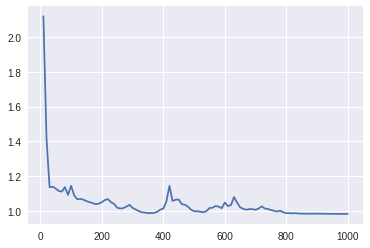

In [40]:
counter = []
loss_history = [] 
iteration_number = 0
for epoch in range(0, Config.train_number_epochs):
    for i, data in enumerate(train_dataloader, 0):
        img0, img1 , label = data
        img0, img1 , label = img0.cuda(), img1.cuda() , label.cuda()
        optimizer.zero_grad()
        output1, output2 = net(img0, img1)
        loss_contrastive = criterion(output1, output2, label)
        loss_contrastive.backward()
        optimizer.step()
        if i %10 == 0 :
            print("Epoch number {}\n Current loss {}\n".format(epoch,loss_contrastive.item()))
            iteration_number +=10
            counter.append(iteration_number)
            loss_history.append(loss_contrastive.item())
show_plot(counter,loss_history)